In [1]:
# from sklearn.datasets import make_multilabel_classification
from torch.utils.data import Dataset
import json
import numpy as np
import torch
import time
from tqdm import tqdm
from NN_Models import *


from preprocessing import for_train

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EMBEDDING = True
X, y = for_train("year_venue", p=0.20250, embedding=EMBEDDING)

delet some useless data: 100%|██████████| 25793/25793 [00:00<00:00, 442508.87it/s]


Number of instance with label :  7460
Number of instance without label(remain) :  1894


authors: 100%|██████████| 25793/25793 [00:04<00:00, 6032.16it/s]


In [3]:
print(X.shape)

N_FEATURES = X.shape[1]

torch.Size([9354, 486])


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

print("Train:")
print("     X_train : ", X_train.shape)
print("     y_train : ", y_train.shape)
print("Test_Kaggle:")
print("     X_test  : ", X_test.shape)
print("     y_test  : ", y_test.shape)


Train:
     X_train :  torch.Size([7483, 486])
     y_train :  torch.Size([7483, 100])
Test_Kaggle:
     X_test  :  torch.Size([1871, 486])
     y_test  :  torch.Size([1871, 100])


In [10]:
print(f"[INFO]: Number of training samples: {X_train.shape[0]}")
print(f"[INFO]: Number of training features: {X_train.shape[1]}")

# train data loader
# train_dataset, train_dataloader = BinaryDataLoader(X_train, y_train, shuffle=True, batch_size=100)
train_dataset, train_dataloader = BinaryDataLoader(X, y, shuffle=True, batch_size=100)

[INFO]: Number of training samples: 7483
[INFO]: Number of training features: 486


100%|██████████| 100/100 [13:08<00:00,  7.89s/it]


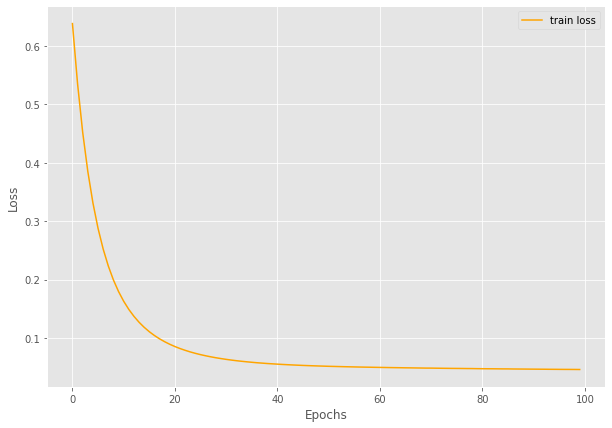

In [11]:
import torch.optim as optim

model = Model()
model.year_venue_model(embedding=EMBEDDING)

learning_rate = 0.001
optimizer = optim.Adam(params=model.year_venue_model(embedding=EMBEDDING).parameters(), lr=learning_rate) # 学习率衰减 / 学习率震荡
epochs = 100
model.train(train_dataloader, optimizer, epochs)
model.save_status("year_venue")
model.plot_loss()

### Test (ignore when submit kaggle)

In [7]:
from evaluation import evaluation

# print some info
print(f"[INFO]: Number of testing samples: {X_test.shape[0]}")
print(f"[INFO]: Number of testing features: {X_test.shape[1]}")

thresholds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

f1_scores = evaluation(model.model, X_test, y_test, thresholds)

[INFO]: Number of testing samples: 1871
[INFO]: Number of testing features: 486


100%|██████████| 9/9 [00:49<00:00,  5.52s/it]


In [8]:
print(thresholds[f1_scores.index(max(f1_scores))])
print(max(f1_scores))

0.1
0.09389756213513412


#### 04/10/2022
- 0.3
- 0.08649579642027334

# Kaggle Predictions

In [13]:
from preprocessing import for_kaggle
from evaluation import kaggle_predict

X_kaggle = for_kaggle('year_venue')

kaggle_predict(model.model, X_kaggle, 'year_venue')

100%|██████████| 800/800 [00:00<00:00, 1545.80it/s]
